https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html

In [1]:
from __future__ import unicode_literals, print_function, division
from csv import reader
from io import open
import unicodedata, string, re
import time, random, math
import sentencepiece as spm
import torch
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from tqdm import tqdm
import numpy as np
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#plt.switch_backend('agg')
device = torch.device("cpu")
def isTrue(x):
    return "yes" if x else "no"
print('is gpu available?', isTrue(torch.cuda.is_available()))

is gpu available? yes


# STANDARD UTILS

In [2]:
#STANDARD UTILS
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))



def showPlot(points,name='time'):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    base = abs((max(points)-min(points))/10)# 10)#base=0.2)
    print('base:',base)
    loc = ticker.MultipleLocator(base)#base)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)
    plt.show()
    #to save image
    if name=='time':
        plt.savefig("loss_graph"+str(time.time())+".png")
    else:
        plt.savefig("loss_graph"+str(name)+".png")
    
#https://www.geeksforgeeks.org/plot-multiple-lines-in-matplotlib/
#assumes same number of epochs in each plot
#assumes same number of plots as lables if lables is used
def comparePlots(plots,lables = None):
    y = range(len(plots[0]))
    for p in range(len(plots)):
        if lables!=None:
            plt.plot(y, plots[p], label = lables[p])
        else:
            plt.plot(y, plots[p])
    if lables!=None:
        plt.legend()
    plt.show()
    
# create data
'''
x = [1,2,3,4,5]
y = [3,3,3,3,3]
plots = [x,y]
lables=['one', 'two']
comparePlots(plots,lables = lables)
'''


"\nx = [1,2,3,4,5]\ny = [3,3,3,3,3]\nplots = [x,y]\nlables=['one', 'two']\ncomparePlots(plots,lables = lables)\n"

# NLP

In [3]:
#initalization params
MAX_LENGTH = 100
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1
            
            
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs




eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]



def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [4]:
#read in data
input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
Trimmed to 13067 sentence pairs
Counting words...
Counted words:
fra 5171
eng 3389
['je sais nager .', 'i m able to swim .']


In [5]:
#randomize samples then split pairs into sets according set_sizes_params
#randomly shuffles pairs (in place I guess)
random.shuffle(pairs)
set_sizes_params = [10000, 1000, 2000]
train_set, val_set, test_set,  = torch.utils.data.random_split(pairs[:sum(set_sizes_params)], set_sizes_params)


# CODE

In [3]:
#FOR LOADING CODE-COMMENT PAIRS DATA
MAX_LENGTH = 100
SOS_token = 0
EOS_token = 1

#import code tokenizer
class Tokenizer:

    def __init__(self, filepath='py_tokenizer.model'):
        self.sp = spm.SentencePieceProcessor(model_file=filepath)

    def encode(self, text, t=int):
        return self.sp.encode(text, out_type=t)

    def decode(self, pieces):
        return self.sp.decode(pieces)

    @staticmethod
    def train(input_file='data/raw_sents.txt', model_prefix='sp_model', vocab_size=30522):
        spm.SentencePieceTrainer.train(input=input_file, model_prefix=model_prefix, vocab_size=vocab_size,
                                       #input_sentence_size=2 ** 16, shuffle_input_sentence=True)
                                       input_sentence_size=number_of_lines, shuffle_input_sentence=True)
        
#instantiate tokenizer model
code_tokenizer = Tokenizer('py_tokenizer.model')


def tokenize_code(code):
    #'''
    tokens = code_tokenizer.encode(code)
    code_tokens = []
    for t in tokens:
        literal = code_tokenizer.decode(t)
        if literal =='':
            literal = ' '
        code_tokens.append(literal)
    return code_tokens
    #'''
    

#LANGUAGE CLASS SHOULD BE THE SAME FOR 
class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence,code=False):
        if code:
            #for code we include white space... will that be a problem?
            for word in tokenize_code(sentence):
            #for word in tokenize_code(sentence):
                self.addWord(word)
        else:
            for word in sentence.split(' '):
                self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1


# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

def readLangs(file, lang1, lang2, reverse=False):
    print("Reading lines...")
    # Read the file and split into lines

    pairs = read_code_commet_pairs(file)
    
    input_lang = Lang('code')
    output_lang = Lang('comment')

    return input_lang, output_lang, pairs


from csv import reader
def read_code_commet_pairs(file):
    with open(file, 'r') as read_obj:
        # pass the file object to reader() to get the reader object
        csv_reader = reader(read_obj)
        # Iterate over each row in the csv using reader object
        pairs = []
        for row in csv_reader:
            # row variable is a list that represents a row in csv
            #row[0] - code
            #row[1] - comment #we have to normalize it (?)
            pairs.append([row[0],normalizeString(row[1])])
        read_obj.close()

    #print('num samples: ', len(pairs))
    return pairs
    
def prepareData(pairs,input_lang, output_lang, num_samples = 10000):
    #UNCOMMENT TO HAVE LIMITED SAMPLE SIZE
    pairs = pairs[1:num_samples+1]
    
    print("Read %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        #ADD SENTENCE CALLED
        input_lang.addSentence(pair[0],code=True)
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


#Nueral Network Functions
def indexesFromSentence(lang, sentence):
    try:
        #return [lang.word2index[word] for word in tokenize_code(sentence)]
        #'''
        if lang.name == 'code':
            #return [lang.word2index[word] for word in tokenize_code(sentence)]
            return [lang.word2index[word] for word in tokenize_code(sentence)]
        #comment
        else:  
            return [lang.word2index[word] for word in sentence.split(' ')]
        #'''
    except:
        print(lang.name)
        print(sentence)
        print(sentence.split(' '))
        input()

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)



In [4]:
#pairs = read_code_commet_pairs('../code-comment-300-300.csv')
num_samples = 50000
lang='py'
file = 'code-comment-'+lang+'.csv'
#READLANG FUNC CALLED
input_lang, output_lang, pairs = readLangs(file, 'code', 'comment', reverse=True)
input_lang, output_lang, pairs = prepareData(pairs,input_lang, output_lang, num_samples=num_samples)
#random.seed()


Reading lines...
Read 21618 sentence pairs
Counting words...
Counted words:
code 6721
comment 10568


In [6]:
#randomize samples then split pairs into sets according set_sizes_params
#randomly shuffles pairs (in place I guess)
random.shuffle(pairs)
set_sizes_params = [20000, 100, 1000]
train_set, val_set, test_set,  = torch.utils.data.random_split(pairs[:sum(set_sizes_params)], set_sizes_params)



In [7]:
train_set[0]

['    def print_output(self, old_text, new_text, filename, equal):\n        \n        pass\n\n',
 'called with the old version new version and filename of a refactored file .']

# MODEL

In [8]:

#Classes
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)#, dropout=0.25) #dan

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        #return torch.zeros(1, 1, self.hidden_size, device=device)
        return torch.randn(1, 1, self.hidden_size, device=device)
    
    
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        #return torch.zeros(1, 1, self.hidden_size, device=device)
        return torch.randn(1, 1, self.hidden_size, device=device)
    
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length
        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        # Learn attention weights
        attn_weights = F.softmax(self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))

        # Compute output
        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        # Apply activation
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        #return torch.zeros(1, 1, self.hidden_size, device=device)
        return torch.randn(1, 1, self.hidden_size, device=device)

# Train, epochs, batching

In [9]:
#https://discuss.pytorch.org/t/add-all-the-loss/39352
#https://machinelearningmastery.com/gentle-introduction-mini-batch-gradient-descent-configure-batch-size/
def train(loss, input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)
    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)
    decoder_hidden = encoder_hidden
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input
            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    return loss, target_length

def trainIters(encoder, decoder, n_iters, batch_size=32, print_every=1000, plot_every=100, learning_rate=0.01, opt=optim.SGD):
    start = time.time()
    plot_losses = []
    val_plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every
    
    #for val
    val_plot_losses = []
    val_print_loss_total = 0  # Reset every print_every
    val_plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = opt(encoder.parameters(),lr=learning_rate)
    decoder_optimizer = opt(decoder.parameters(),lr=learning_rate)

    criterion = nn.NLLLoss()
    #for val
    val_criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()
        loss = 0
        val_loss = 0
        total_target_length=0
        
        ###train_set
        #do the data loading here to avoid having to store all of it in one list
        training_pairs = [tensorsFromPair(random.choice(train_set)) for i in range(batch_size)]
        #no progross bar
        for pair in training_pairs:
        #progress bar on each epoch
        #for i in tqdm(range(len(training_pairs))):
        #    pair = training_pai]rs[i
            input_tensor  = pair[0]
            target_tensor = pair[1]
            loss, target_length = train(loss, 
                                        input_tensor, 
                                        target_tensor, 
                                        encoder, 
                                        decoder, 
                                        encoder_optimizer, 
                                        decoder_optimizer, 
                                        criterion)
            total_target_length += target_length
        
        
        loss.backward()
        encoder_optimizer.step()
        decoder_optimizer.step()
        
        print_loss_total+=(loss.item()/total_target_length)
        plot_loss_total+=(loss.item()/total_target_length)
        
        
        ##TODO -- add validation, only needs to be calculated as compared to an "epoc of insterest" (ie to print or graph)
        if iter % print_every == 0:
            print_loss_avg = print_loss_total / (print_every)
            print_loss_total = 0
            #print('epoch %f : %s (%d %d%%) %.4f' % (iter, timeSince(start, iter / n_iters), iter, iter / n_iters * 100, print_loss_avg))
            #print('epoch %f : %s (%d %d%%) test: %.4f ' % (round(iter), 
            #                                                           timeSince(start, iter / n_iters), 
            #                                                           iter, iter / n_iters * 100, 
            #                                                           print_loss_avg))
            
            #'''
            total_target_length=0
            #batch size portion of val
            val_pairs = [tensorsFromPair(random.choice(val_set)) for i in range(batch_size)]
            #all
            #val_pairs = [tensorsFromPair(val_set[i]) for i in range(len(val_set))]
            for pair in val_pairs:
                input_tensor  = pair[0]
                target_tensor = pair[1]
                val_loss, target_length = train(val_loss, 
                                                input_tensor, 
                                                target_tensor, 
                                                encoder, 
                                                decoder, 
                                                encoder_optimizer, 
                                                decoder_optimizer, 
                                                val_criterion)
                total_target_length += target_length
            
            print('epoch '+str(iter)+': %s (%d %d%%) test %.4f  -- val: %.4f' % ( 
                                                                       timeSince(start, iter / n_iters), 
                                                                       iter, iter / n_iters * 100, 
                                                                       print_loss_avg, 
                                                                       val_loss.item()/total_target_length))
            
            val_loss = 0
                
            #'''
        if iter % plot_every == 0:
            
            plot_loss_avg = plot_loss_total / (plot_every)
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
            
            #all this V is for validation
            #'''
            total_target_length=0
            #only batch size
            #val_pairs = [tensorsFromPair(random.choice(val_set)) for i in range(batch_size)]
            #all
            val_pairs = [tensorsFromPair(val_set[i]) for i in range(len(val_set))]
            for pair in val_pairs:
                input_tensor  = pair[0]
                target_tensor = pair[1]
                val_loss, target_length = train(val_loss, 
                                                input_tensor, 
                                                target_tensor, 
                                                encoder, 
                                                decoder, 
                                                encoder_optimizer, 
                                                decoder_optimizer, 
                                                val_criterion)
                total_target_length += target_length
            
            val_plot_losses.append(val_loss.item()/total_target_length)
            val_loss = 0
            #'''
            
            
    return plot_losses, val_plot_losses



In [10]:
#model_name = 'Code_25kEpochs_14kSamples_3overlap_3natural_splits'
model_name = 'code_3overlap_2stopwords_FINAL'

In [12]:
#opt = optim.Adadelta   #viable
#opt = optim.Adagrad    #viable
opt = optim.Adam       #viable #best?
#opt = optim.AdamW      #viable
#opt = optim.SparseAdam #viable
#opt = optim.ASGD       #viable   
#opt = optim.LBFGS      #viable
#opt = optim.NAdam      #viable
#opt = optim.RAdam      #viable
#opt = optim.RMSprop    #viable
#opt = optim.Rprop      #viable
#opt=optim.SGD

#configuration
teacher_forcing_ratio = 0.5 # Amount of tokens to learn #SHOULD BE INTEGRATED AS A PRAM BUT ITS OK FOR NOW
hidden_size = 1000#256 # Hidden dimension

#Initialize Architecture
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
#normal dropout is 0.01
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=1).to(device)

#mini batching?
batch_size = 5
#all
#batch_size = len(train_set)
plot_losses, val_losses = trainIters(encoder1, attn_decoder1, n_iters=35000, 
           batch_size=batch_size, 
           print_every=50, 
           plot_every=50,
           learning_rate=0.001/batch_size,
           opt=opt)


'''
plot_losses = trainIters(encoder1, attn_decoder1, n_iters=25000, 
           batch_size=batch_size, 
           print_every=100, 
           plot_every=50,
           learning_rate=0.01/batch_size,
           opt=opt)
'''
showPlot(plot_losses,name=model_name)
showPlot(val_losses)
comparePlots([plot_losses,val_losses])

epoch 50: 4m 45s (- 3328m 35s) (50 0%) test 6.4067  -- val: 4.4432
epoch 100: 9m 43s (- 3391m 41s) (100 0%) test 5.2245  -- val: 5.3872
epoch 150: 14m 24s (- 3347m 11s) (150 0%) test 5.1130  -- val: 5.7702
epoch 200: 19m 15s (- 3350m 20s) (200 0%) test 5.0428  -- val: 4.4621
epoch 250: 24m 16s (- 3374m 16s) (250 0%) test 5.0177  -- val: 4.7169
epoch 300: 29m 24s (- 3402m 14s) (300 0%) test 4.9381  -- val: 4.4750
epoch 350: 34m 34s (- 3423m 43s) (350 1%) test 4.9784  -- val: 5.6070
epoch 400: 40m 8s (- 3472m 11s) (400 1%) test 4.9619  -- val: 5.0808
epoch 450: 45m 4s (- 3461m 11s) (450 1%) test 4.7938  -- val: 4.9626
epoch 500: 49m 42s (- 3429m 47s) (500 1%) test 4.8364  -- val: 4.7476
epoch 550: 54m 47s (- 3431m 36s) (550 1%) test 4.7063  -- val: 5.8581
epoch 600: 59m 20s (- 3402m 9s) (600 1%) test 4.8963  -- val: 4.7530
epoch 650: 63m 43s (- 3367m 31s) (650 1%) test 4.8210  -- val: 4.4806
epoch 700: 68m 38s (- 3363m 28s) (700 2%) test 4.5557  -- val: 4.7369
epoch 750: 73m 40s (- 3364m

epoch 5750: 524m 47s (- 2669m 36s) (5750 16%) test 3.3849  -- val: 4.4598
epoch 5800: 528m 55s (- 2662m 49s) (5800 16%) test 3.4467  -- val: 4.8942
epoch 5850: 532m 55s (- 2655m 32s) (5850 16%) test 3.4519  -- val: 3.1422
epoch 5900: 536m 56s (- 2648m 18s) (5900 16%) test 3.4171  -- val: 3.9897
epoch 5950: 541m 8s (- 2642m 2s) (5950 17%) test 3.3450  -- val: 2.8766
epoch 6000: 545m 11s (- 2635m 4s) (6000 17%) test 3.4493  -- val: 4.5314
epoch 6050: 549m 10s (- 2627m 53s) (6050 17%) test 3.4877  -- val: 4.5374
epoch 6100: 553m 20s (- 2621m 34s) (6100 17%) test 3.3595  -- val: 3.7929
epoch 6150: 557m 22s (- 2614m 39s) (6150 17%) test 3.3170  -- val: 4.7220
epoch 6200: 561m 26s (- 2607m 58s) (6200 17%) test 3.4532  -- val: 2.9680
epoch 6250: 565m 32s (- 2601m 29s) (6250 17%) test 3.4399  -- val: 3.3247
epoch 6300: 569m 32s (- 2594m 36s) (6300 18%) test 3.3680  -- val: 3.1981
epoch 6350: 573m 37s (- 2588m 6s) (6350 18%) test 3.5233  -- val: 3.5246
epoch 6400: 577m 40s (- 2581m 29s) (6400 1

epoch 11300: 971m 40s (- 2037m 55s) (11300 32%) test 2.6470  -- val: 3.8343
epoch 11350: 975m 37s (- 2032m 54s) (11350 32%) test 2.4826  -- val: 4.1540
epoch 11400: 979m 29s (- 2027m 43s) (11400 32%) test 2.4964  -- val: 4.8172
epoch 11450: 983m 38s (- 2023m 7s) (11450 32%) test 2.8092  -- val: 4.2855
epoch 11500: 987m 48s (- 2018m 33s) (11500 32%) test 2.7465  -- val: 2.8448
epoch 11550: 992m 8s (- 2014m 21s) (11550 33%) test 2.6221  -- val: 4.4798
epoch 11600: 996m 16s (- 2009m 43s) (11600 33%) test 2.6675  -- val: 3.7842
epoch 11650: 1000m 17s (- 2004m 52s) (11650 33%) test 2.5944  -- val: 4.2972
epoch 11700: 1004m 18s (- 2000m 1s) (11700 33%) test 2.3724  -- val: 3.5791
epoch 11750: 1008m 26s (- 1995m 26s) (11750 33%) test 2.7125  -- val: 4.5319
epoch 11800: 1012m 25s (- 1990m 31s) (11800 33%) test 2.4969  -- val: 3.3004
epoch 11850: 1016m 19s (- 1985m 28s) (11850 33%) test 2.4553  -- val: 2.5462
epoch 11900: 1020m 23s (- 1980m 44s) (11900 34%) test 2.5815  -- val: 3.3191
epoch 119

epoch 16650: 1408m 12s (- 1551m 59s) (16650 47%) test 2.1196  -- val: 3.0459
epoch 16700: 1412m 14s (- 1547m 32s) (16700 47%) test 2.1280  -- val: 3.7830
epoch 16750: 1416m 22s (- 1543m 12s) (16750 47%) test 1.9487  -- val: 4.5333
epoch 16800: 1420m 26s (- 1538m 49s) (16800 48%) test 1.9647  -- val: 5.8313
epoch 16850: 1424m 27s (- 1534m 21s) (16850 48%) test 2.1797  -- val: 2.8385
epoch 16900: 1428m 32s (- 1529m 59s) (16900 48%) test 2.1729  -- val: 4.8116
epoch 16950: 1432m 36s (- 1525m 34s) (16950 48%) test 2.1040  -- val: 3.3641
epoch 17000: 1436m 49s (- 1521m 20s) (17000 48%) test 2.2083  -- val: 2.5819
epoch 17050: 1440m 56s (- 1517m 0s) (17050 48%) test 1.9654  -- val: 4.4554
epoch 17100: 1444m 58s (- 1512m 34s) (17100 48%) test 1.9951  -- val: 5.0546
epoch 17150: 1449m 9s (- 1508m 18s) (17150 49%) test 2.0376  -- val: 4.5754
epoch 17200: 1453m 14s (- 1503m 56s) (17200 49%) test 2.0367  -- val: 3.9927
epoch 17250: 1457m 14s (- 1499m 28s) (17250 49%) test 2.0893  -- val: 2.4547
e

epoch 22000: 1848m 50s (- 1092m 29s) (22000 62%) test 1.7096  -- val: 5.1412
epoch 22050: 1852m 55s (- 1088m 13s) (22050 63%) test 1.6476  -- val: 5.4518
epoch 22100: 1856m 59s (- 1083m 56s) (22100 63%) test 1.8290  -- val: 4.4561
epoch 22150: 1861m 9s (- 1079m 43s) (22150 63%) test 1.6161  -- val: 4.4890
epoch 22200: 1865m 18s (- 1075m 29s) (22200 63%) test 1.6476  -- val: 4.5252
epoch 22250: 1869m 23s (- 1071m 13s) (22250 63%) test 1.5375  -- val: 4.5606
epoch 22300: 1873m 34s (- 1067m 0s) (22300 63%) test 1.6350  -- val: 5.5910
epoch 22350: 1877m 36s (- 1062m 42s) (22350 63%) test 1.6536  -- val: 3.7058
epoch 22400: 1881m 46s (- 1058m 30s) (22400 64%) test 1.6716  -- val: 4.6785
epoch 22450: 1886m 5s (- 1054m 21s) (22450 64%) test 1.6308  -- val: 3.4393
epoch 22500: 1890m 17s (- 1050m 9s) (22500 64%) test 1.5738  -- val: 2.1280
epoch 22550: 1894m 21s (- 1045m 53s) (22550 64%) test 1.6652  -- val: 4.1686
epoch 22600: 1898m 27s (- 1041m 37s) (22600 64%) test 1.6137  -- val: 3.3480
epo

epoch 27400: 2297m 9s (- 637m 10s) (27400 78%) test 1.2794  -- val: 5.3358
epoch 27450: 2301m 16s (- 632m 57s) (27450 78%) test 1.2217  -- val: 2.3259
epoch 27500: 2305m 27s (- 628m 45s) (27500 78%) test 1.4594  -- val: 4.5087
epoch 27550: 2309m 31s (- 624m 32s) (27550 78%) test 1.3397  -- val: 2.9757
epoch 27600: 2313m 30s (- 620m 17s) (27600 78%) test 1.2373  -- val: 3.5717
epoch 27650: 2317m 39s (- 616m 5s) (27650 79%) test 1.3321  -- val: 3.4143
epoch 27700: 2321m 56s (- 611m 55s) (27700 79%) test 1.2322  -- val: 3.2087
epoch 27750: 2326m 11s (- 607m 44s) (27750 79%) test 1.2517  -- val: 6.7993
epoch 27800: 2330m 15s (- 603m 31s) (27800 79%) test 1.3042  -- val: 5.2273
epoch 27850: 2334m 17s (- 599m 17s) (27850 79%) test 1.2636  -- val: 2.9872
epoch 27900: 2338m 23s (- 595m 4s) (27900 79%) test 1.2622  -- val: 4.4895
epoch 27950: 2342m 33s (- 590m 52s) (27950 79%) test 1.4183  -- val: 5.1438
epoch 28000: 2346m 44s (- 586m 41s) (28000 80%) test 1.3418  -- val: 3.3821
epoch 28050: 23

epoch 32850: 2750m 57s (- 180m 2s) (32850 93%) test 1.1514  -- val: 5.5445
epoch 32900: 2755m 1s (- 175m 51s) (32900 94%) test 1.1289  -- val: 2.3426
epoch 32950: 2759m 10s (- 171m 39s) (32950 94%) test 1.0364  -- val: 2.4133
epoch 33000: 2763m 25s (- 167m 28s) (33000 94%) test 1.1071  -- val: 4.9950
epoch 33050: 2767m 37s (- 163m 17s) (33050 94%) test 1.1432  -- val: 4.2414
epoch 33100: 2771m 55s (- 159m 6s) (33100 94%) test 1.1248  -- val: 3.8363
epoch 33150: 2776m 14s (- 154m 55s) (33150 94%) test 1.0666  -- val: 3.3549
epoch 33200: 2780m 22s (- 150m 44s) (33200 94%) test 1.0167  -- val: 4.6787
epoch 33250: 2784m 26s (- 146m 32s) (33250 95%) test 1.1464  -- val: 3.9720
epoch 33300: 2788m 37s (- 142m 21s) (33300 95%) test 1.1331  -- val: 3.1520
epoch 33350: 2792m 41s (- 138m 10s) (33350 95%) test 1.0567  -- val: 5.0436
epoch 33400: 2796m 52s (- 133m 58s) (33400 95%) test 1.0107  -- val: 6.4511
epoch 33450: 2800m 57s (- 129m 47s) (33450 95%) test 1.0987  -- val: 2.6662
epoch 33500: 28

KeyboardInterrupt: 

In [65]:
#plot_losses

NameError: name 'plot_losses' is not defined

base: 0.5380633423133282


<Figure size 432x288 with 0 Axes>

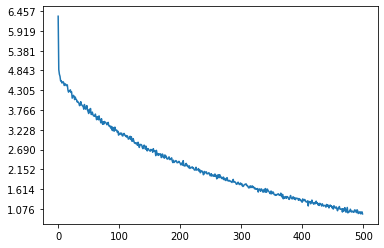

base: 0.2957384725479796


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

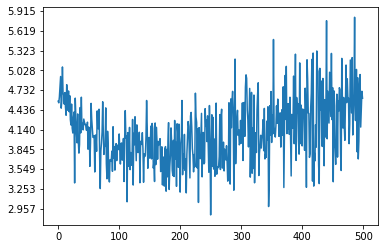

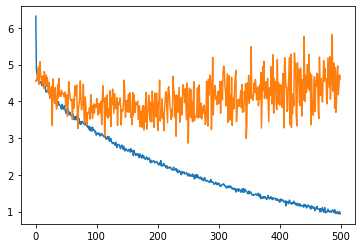

In [18]:
#CODE
showPlot(plot_losses,name=model_name)
showPlot(val_losses)
comparePlots([plot_losses,val_losses])

In [12]:
# Name Weights
filename_weights_encoder = 'model_encoder_'+model_name
filename_weights_decoder = 'model_decoder_'+model_name

In [14]:
#save Weights
torch.save(encoder1, filename_weights_encoder)
torch.save(attn_decoder1, filename_weights_decoder)

In [13]:
# Reload weights
encoder1 = torch.load(filename_weights_encoder)
attn_decoder1 = torch.load(filename_weights_decoder)

In [32]:
plots=[]
lables=[]
#opt = optim.Adadelta   #viable
#opt = optim.Adagrad    #viable
#opt = optim.Adam       #viable
#opt = optim.AdamW      #viable
#opt = optim.SparseAdam #viable
#opt = optim.ASGD       #viable   
#opt = optim.LBFGS      #viable
#opt = optim.NAdam      #viable
#opt = optim.RAdam      #viable
#opt = optim.RMSprop    #viable
#opt = optim.Rprop      #viable
#opt=optim.SGD          #viable

'''
opts = [optim.Adadelta, optim.Adam, optim.AdamW,
        optim.ASGD, optim.NAdam, 
        optim.RAdam, optim.SGD]
       #issue with optim.SparseAdam, optim.LBFGS, optim.Rprop, optim.Adagrad
       #BAD: optim.RMSprop,
'''
#works[]
opts = [optim.Adam, optim.AdamW, optim.NAdam, optim.SGD]

#opts = [optim.Adam, optim.SGD] 
epochs=10000
print_every=50
plot_every=100
learning_rate=0.01
batch_size = 25
teacher_forcing_ratio = 0.5
hidden_size = 256
dropout = 0.01

for i in opts: #range(3):
    
    print('------'*8)
    #
    #lables.append(str(i/10))
    lables.append(i.__name__)
    print('Attribut: optimizer -',i.__name__)
    print('------'*8)
    
    #model info

    encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
    attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=dropout).to(device)
    
    #train info
    plot_losses = trainIters(encoder1, attn_decoder1, 
                             n_iters=epochs, 
                             batch_size = batch_size,
                             print_every=print_every,
                             plot_every=plot_every, 
                             learning_rate=learning_rate/batch_size,
                             opt=i)
    showPlot(plot_losses,name=i.__name__)
    plots.append(plot_losses)

    
print('******'*8)
print('final results')
print('******'*8)
comparePlots(plots,lables)

------------------------------------------------
Attribut: optimizer - Adam
------------------------------------------------
epoch 50.000000 : 2m 24s (- 477m 41s) (50 0%) 5.2151
epoch 100.000000 : 4m 55s (- 486m 45s) (100 1%) 4.5280
epoch 150.000000 : 7m 26s (- 488m 44s) (150 1%) 4.4552
epoch 200.000000 : 10m 6s (- 495m 35s) (200 2%) 4.5557
epoch 250.000000 : 12m 46s (- 497m 54s) (250 2%) 4.4407
epoch 300.000000 : 15m 16s (- 494m 6s) (300 3%) 4.3341
epoch 350.000000 : 17m 48s (- 491m 3s) (350 3%) 4.2920
epoch 400.000000 : 20m 25s (- 490m 18s) (400 4%) 4.2372
epoch 450.000000 : 23m 0s (- 488m 8s) (450 4%) 4.0863
epoch 500.000000 : 25m 33s (- 485m 27s) (500 5%) 4.1177
epoch 550.000000 : 28m 9s (- 483m 50s) (550 5%) 4.1379
epoch 600.000000 : 30m 49s (- 482m 53s) (600 6%) 4.1853
epoch 650.000000 : 33m 25s (- 480m 54s) (650 6%) 4.0612
epoch 700.000000 : 36m 2s (- 478m 53s) (700 7%) 3.9867
epoch 750.000000 : 38m 43s (- 477m 36s) (750 7%) 3.9652
epoch 800.000000 : 41m 19s (- 475m 14s) (800 8%

KeyboardInterrupt: 

In [28]:
count=0
ind=[]
for i in plots:
    
    x = sum(i[40:])/len(i[40:])
    if x<3.5:
        print(x)
        print(count)
        ind.append(count)
    
    count+=1
    

3.4628065006372335
1
3.44206507887926
2
3.4206997854911374
4
3.487573026213848
6


In [30]:
opts = [optim.Adadelta, optim.Adam, optim.AdamW,
        optim.ASGD, optim.NAdam, 
        optim.RAdam, optim.SGD]
for i in d

optim.Adam,optim.AdamW,optim.NAdam,optim.SGD

[1, 2, 4, 6]

In [14]:
import nltk
from nltk.translate.bleu_score import sentence_bleu 
from nltk.translate.bleu_score import SmoothingFunction
from nltk.translate.chrf_score import sentence_chrf
from nltk.translate.gleu_score import sentence_gleu
from nltk.translate.meteor_score import single_meteor_score
from nltk.translate.nist_score import sentence_nist
from nltk.translate.ribes_score import sentence_ribes
from nltk.tokenize import word_tokenize
nltk.download('wordnet') #reqired for meteor
import pickle
import string
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Polygon
from tqdm import tqdm

from nltk.tokenize import WordPunctTokenizer

[nltk_data] Downloading package wordnet to /home/ajs568/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [15]:
def Evaluate(reference, hypothesis, d):
    
    local=[]
    
    #BLEU structure
    #references -- (list(list(str))) – reference sentences
    #hypothesis (list(str)) – a hypothesis sentence
    
    average_bleu=[]
    
    #BLEU - Smoothing Method 1
    try:
        score = sentence_bleu(reference, hypothesis, smoothing_function=SmoothingFunction().method1)
        d['BLUE_m1'].append(min(score,1))
        local.append(['BLUE_m1',min(score,1)])
        average_bleu.append(min(score,1))
    except Exception as e:
        local.append(['BLUE_m1',e])
        pass
        #d['BLUE_m1'].append(None)
    
    #BLEU - Smoothing Method 2
    try:
        score = sentence_bleu(reference, hypothesis, smoothing_function=SmoothingFunction().method2)
        d['BLUE_m2'].append(min(score,1))
        local.append(['BLUE_m2',min(score,1)])
        average_bleu.append(min(score,1))
    except Exception as e:
        local.append(['BLUE_m2',e])
        pass
        #d['BLUE_m2'].append(None)
        
    #BLEU - Smoothing Method 3
    try:
        score = sentence_bleu(reference, hypothesis, smoothing_function=SmoothingFunction().method3)
        d['BLUE_m3'].append(min(score,1))
        local.append(['BLUE_m3',min(score,1)])
        average_bleu.append(min(score,1))
    except Exception as e:
        local.append(['BLUE_m3',e])
        pass
        #d['BLUE_m3'].append(None)
    
    #BLEU - Smoothing Method 4
    try:
        score = sentence_bleu(reference, hypothesis, smoothing_function=SmoothingFunction().method4)
        d['BLUE_m4'].append(min(score,1))
        local.append(['BLUE_m4',min(score,1)])
        average_bleu.append(min(score,1))
    except Exception as e:
        local.append(['BLUE_m4',e])
        pass
        #d['BLUE_m4'].append(None)
    
    #BLEU - Smoothing Method 5
    try:
        score = sentence_bleu(reference, hypothesis, smoothing_function=SmoothingFunction().method5)
        d['BLUE_m5'].append(min(score,1))
        local.append(['BLUE_m5',min(score,1)])
        average_bleu.append(min(score,1))
    except Exception as e:
        local.append(['BLUE_m5',e])
        pass
        #d['BLUE_m5'].append(None)
        
    #BLEU - Smoothing Method 6
    try:
        score = sentence_bleu(reference, hypothesis, smoothing_function=SmoothingFunction().method6)
        d['BLUE_m6'].append(min(score,1))
        local.append(['BLUE_m6',min(score,1)])
        average_bleu.append(min(score,1))
    except Exception as e:
        local.append(['BLUE_m6',e])
        pass
        #d['BLUE_m6'].append(None)
        
    #BLEU - Smoothing Method 7
    try:
        score = sentence_bleu(reference, hypothesis, smoothing_function=SmoothingFunction().method7)
        d['BLUE_m7'].append(min(score,1))
        local.append(['BLUE_m7',min(score,1)])
        average_bleu.append(min(score,1))
    except Exception as e:
        local.append(['BLUE_m7',e])
        pass
        #d['BLUE_m7'].append(None)

        
    #AVERAGE OF BLEU SCORE
    try:
        score = sum(average_bleu)/len(average_bleu)
        d['BLUE'].append(score)
        local.append(['BLUE',score])
    except Exception as e:
        local.append(['BLUE',e])
        pass
    
    #CHRF
    #references (list(str) / str) – reference sentence
    #hypothesis (list(str) / str) – a hypothesis sentence
    chrf_reference = reference[0]
    chrf_hypothesis = hypothesis
    try:
        score = sentence_chrf(chrf_reference, chrf_hypothesis)
        d['CHRF'].append(min(score,1))
        local.append(['CHRF',min(score,1)])
    except Exception as e:
        local.append(['CHRF',e])
        pass
        #d['CHRF'].append(None)

    #GLUE
    #references (list(list(str))) – a list of reference sentences
    #hypothesis (list(str)) – a hypothesis sentence
    try:
        score = sentence_gleu(reference, hypothesis)
        d['GLUE'].append(min(score,1))
        local.append(['GLUE',min(score,1)])
    except Exception as e:
        local.append(['GLUE',e])
        pass
        #d['GLUE'].append(None)

    #METEOR
    #references (list(str)) – reference sentences 
    #hypothesis (str) – a hypothesis sentence
    meteor_reference = ' '.join(reference[0])
    meteor_hypothesis = ' '.join(hypothesis)
    try:
        score = single_meteor_score(meteor_reference, meteor_hypothesis)
        d['METEOR'].append(min(score,1))
        local.append(['METEOR',min(score,1)])
    except Exception as e:
        local.append(['METEOR',e])
        pass
        #d['METEOR'].append(None)

    #NIST -- excluded because not sure how to compare
    #references (list(list(str))) – reference sentences
    #hypothesis (list(str)) – a hypothesis sentence
    '''
    try:
        score = sentence_nist(reference, hypothesis)
        d['NIST'].append(score)
        local.append(['NIST',score])
    except Exception as e:
        local.append(['NIST',e])
        pass
        #d['NIST'].append(None)
    '''

    #RIBES
    #references (list(list(str))) - a list of reference sentences
    #hypothesis (list(str)) – a hypothesis sentence
    try:
        score = sentence_ribes(reference, hypothesis)
        d['RIBES'].append(min(score,1))
        local.append(['RIBES',min(score,1)])
    except Exception as e:
        local.append(['RIBES',e])
        pass
        #d['RIBES'].append(None)

    
    #print(local)

In [16]:
import ast
#import import_ipynb
#import Extract_Python_Pairs as EPP
#https://docs.python.org/3/library/tokenize.html
import tokenize
import io
import numpy as np
from tqdm import tqdm #inline progress bar (quality of life)
import collections

key_words = ['False','await','else','import','pass',
            'None','break','except','in','raise',
            'True','class','finally','is','return',
            'and','continue','for','lambda','try',
            'as','def','from','nonlocal','while',
            'assert','del','global','not','with',
            'async','elif','if','or','yield']

#https://docs.python.org/3/library/tokenize.html
def get_vars(code_snippet):
    #tokens = tokenize.tokenize(io.BytesIO(code_snippet.encode('utf-8')).readline)
    tokens = tokenize.tokenize(io.BytesIO(code_snippet.encode('utf-8')).readline)
    
    #for keeping track of variables
    variables = []
    try: #for issues with tokenizing
        for token in tokens:

            if token.type not in [0,57,58,59,60,61,62,63,256]:



                #keyword or variable
                if token.type == 1:
                    variables.append(token.string)
                    #avoidkey word
                    #if token.string not in key_words:
                    #    variables.append(token.string)

                #string
                elif token.type == 3:
                    variables.append(token.string)

        return variables
    
    except:
        return []
import re
def clean_comment(text):
    words = re.split(r'\W+', text)
    words = [word.lower() for word in words]
    words = ' '.join(words)
    words = ''.join([i for i in words if i.isalpha() or i==' '])
    words = re.sub(' +', ' ', words)
    
    return words

def clean_vars(var_list):
    clean_var_list =  ' '.join(var_list)
    clean_var_list =  clean_var_list.replace('_',' ')
    clean_var_list = clean_var_list.split(' ')
    return clean_var_list

# Python program to illustrate the intersection
# of two lists using set() method
def intersection(lst1, lst2):
    return list(set(lst1) & set(lst2))

def code_comment_cohesion(code, comment):
    code_vars = get_vars(code)
    clean_var_list = clean_vars(code_vars)
    words = clean_comment(comment).split(' ')
    shared_words = intersection(words, clean_var_list)
    return shared_words

In [123]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)
        
        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]
        #return decoded_words, decoder_attentions[:di + 1,:len(sentence)+1]
    
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(test_set)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')
        
        
import pickle
def save_attn_pkl(encoder, decoder, n=10):
    attn_pkl = {}
    for i in range(n):  
        pair = random.choice(test_set)
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        attn_pkl[i] = {'input':pair[0], 'output':output_sentence, 'attn':attentions}
    
    output_path = open('attn.pkl', 'wb')
    pickle.dump(attn_pkl, output_path)
    output_path.close()
    
    
def showAttention(input_sentence, output_words, attentions):
    print(attentions.size())
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    
def showAttention2(input_sentence, output_words, attentions):
    
    tokenized_input = tokenize_code(input_sentence)
    
    new_l = []
    #for i, tok in enumerate(input_sentence.split(' ')):
    for i, tok in enumerate(tokenized_input):
        tmp = tok
        if len(tmp) == 0:
            continue
        else:
            while (len(tokenized_input) > 0) and (len(tmp) > 0):
                if tokenized_input[0] == tmp[:len(tokenized_input[0])]:
                    tmp = tmp.replace(tokenized_input[0], '')
                    new_l.append(tokenized_input[0])
                    tokenized_input.pop(0)
                else:
                    break

    
    
    
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + tokenize_code(input_sentence) +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)
    print(output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    
def showScaledAttention(input_sentence, output_words, attentions):
    
    #wordpunct_tokenize = WordPunctTokenizer().tokenize
    #tokenized_input = wordpunct_tokenize(input_sentence)
    tokenized_input = tokenize_code(input_sentence)
    
    
    '''
    new_l = []
    #for i, tok in enumerate(input_sentence.split(' ')):
    for i, tok in enumerate(tokenized_input):
        tmp = tok
        if len(tmp) == 0:
            continue
        else:
            while (len(tokenized_input) > 0) and (len(tmp) > 0):
                if tokenized_input[0] == tmp[:len(tokenized_input[0])]:
                    tmp = tmp.replace(tokenized_input[0], '')
                    if '_' in tokenized_input[0]:
                        new_l.extend(tokenized_input[0].split('_'))
                    else:
                        if tokenized_input[0][0] not in string.punctuation:
                            new_l.append(tokenized_input[0])
                        else:
                            if '=' in tokenized_input[0]:
                                new_l.append(tokenized_input[0])
                    tokenized_input.pop(0)
                else:
                    break
    '''

    #a = attentions.numpy()[:, :len(tokenized_input)]
    a = attentions.numpy()[1:, :len(tokenized_input)+1]
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(a)
    fig.colorbar(cax)
    # Set up axes
    # ax.set_xticklabels([''] + inp.split(' ') + ['<EOS>'], rotation=90)
    ax.set_xticklabels([''] + tokenized_input + ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)
    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    
    
    
    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    #showAttention(input_sentence, output_words, attentions)
    #showAttention2(input_sentence, output_words, attentions)
    showScaledAttention(input_sentence, output_words, attentions)

    
def evaluateAndShowMetrics(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(test_set)
        print('--------------------------')
        print(pair[0])
        print('--------------------------')
        print('Original Comment:', pair[1])
        print('--------------------------')
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('Generated Comment:', output_sentence[:-6])
        print('--------------------------')
        print('Blue Score:',sentence_bleu([pair[1]], output_sentence[:-6]))
        print('--------------------------')
        print('')
        
def evaluateAndShowMetricTable(encoder, decoder, n=10):
    d={'BLUE':[],'BLUE_m1':[],'BLUE_m2':[],'BLUE_m3':[],'BLUE_m4':[],
       'BLUE_m5':[],'BLUE_m6':[],'BLUE_m7':[],'CHRF':[],
       'GLUE':[], 'METEOR':[],'NIST':[], 'RIBES':[]}
    
    for i in tqdm(range(n)):
        pair = random.choice(test_set)
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        reference  = [pair[1]]
        hypothesis = output_sentence[:-6]
        Evaluate(reference,hypothesis,d)
        
    fig = plt.figure(figsize =(10, 7)) 
    '''    
    data = [d['BLUE'],d['CHRF'],d['GLUE'], d['METEOR'], d['RIBES']]
    plt.xticks([1, 2, 3, 4,5], ['BLEU','CHRF','GLUE', 'METEOR', 'RIBES'])
    '''
    data = [d['BLUE'],d['CHRF'],d['GLUE'], d['RIBES']]
    plt.xticks([1, 2, 3, 4], ['BLEU','CHRF','GLUE', 'RIBES'])

    # Creating plot 
    plt.boxplot(data) 

    # show plot 
    plt.show() 
    
def wrong_answers_only(encoder, decoder, n=10, plot=True, side_by_side=True):
    d={'BLUE':[],'BLUE_m1':[],'BLUE_m2':[],'BLUE_m3':[],'BLUE_m4':[],
       'BLUE_m5':[],'BLUE_m6':[],'BLUE_m7':[],'CHRF':[],
       'GLUE':[], 'METEOR':[],'NIST':[], 'RIBES':[]}
    
    for i in tqdm(range(n)):
        pair = random.choice(test_set)
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        
        BLEU = sentence_bleu([pair[1]], output_sentence[:-6])
        if BLEU<=1:
            
            if side_by_side:
                print('>', pair[0])
                print('=', pair[1])
                print('<', output_sentence[:-6])
                print('BLEU:',BLEU)
                print('')

            reference  = [pair[1]]
            hypothesis = output_sentence[:-6]
            Evaluate(reference,hypothesis,d)
    if plot:
        
        fig = plt.figure(figsize =(10, 7)) 
        #data = [d['BLUE'],d['CHRF'],d['GLUE'], d['METEOR'], d['RIBES']]
        #plt.xticks([1, 2, 3, 4, 5], ['BLEU','CHRF','GLUE', 'METEOR', 'RIBES'])
        #plt.xticks(['BLEU','CHRF','GLUE', 'METEOR', 'RIBES'])
        
        data = [d['BLUE'],d['CHRF'],d['GLUE'], d['RIBES']]
        plt.xticks([1, 2, 3, 4], ['BLEU','CHRF','GLUE', 'RIBES'])

        # Creating plot 
        
        plt.boxplot(data) 

        # show plot 
        plt.show() 
        
from itertools import groupby
def best_answers_only(encoder, decoder, n=10, plot=True, side_by_side=True, random_choice=True, show_attn=True):
    d={'BLUE':[],'BLUE_m1':[],'BLUE_m2':[],'BLUE_m3':[],'BLUE_m4':[],
       'BLUE_m5':[],'BLUE_m6':[],'BLUE_m7':[],'CHRF':[],
       'GLUE':[], 'METEOR':[],'NIST':[], 'RIBES':[]}
    
    for i in tqdm(range(n)):
        if random_choice:
            pair = random.choice(test_set)
        else:
            pair = test_set[i]
            
        
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        
        #remove consecutaively repeated words
        #https://stackoverflow.com/questions/5738901/removing-elements-that-have-consecutive-duplicates
        output_words = [x for x, y in groupby(output_words) if len(list(y)) < 2]
        
        output_sentence = ' '.join(output_words)
        
        shared_words = code_comment_cohesion(str(pair[0]),output_sentence)

        
        BLEU = sentence_bleu([pair[1]], output_sentence[:-6])
        if BLEU<=1 and len(shared_words)>2:
            
            if side_by_side:
                print('')
                print('--------------------------')
                print(pair[0])
                print('--------------------------')
                print('Original Comment:', pair[1])
                print('--------------------------')
                print('Generated Comment:', output_sentence[:-6])
                print('--------------------------')
                print('Blue Score:',BLEU)
                print('--------------------------')
                print('')
                
                #shows an attention map between code and generated comment
                if show_attn:
                    showScaledAttention(pair[0], output_words, attentions)

            reference  = [pair[1]]
            hypothesis = output_sentence[:-6]
            Evaluate(reference,hypothesis,d)
            
                
                
    if plot:
        

        plt.figure(figsize =(10, 7)) 
        #data = [d['BLUE'],d['CHRF'],d['GLUE'], d['METEOR'], d['RIBES']]
        #plt.xticks([1, 2, 3, 4, 5], ['BLEU','CHRF','GLUE', 'METEOR', 'RIBES'])
        #plt.xticks(['BLEU','CHRF','GLUE', 'METEOR', 'RIBES'])
        data = [d['BLUE'],d['CHRF'],d['GLUE'], d['RIBES']]
        #plt.xticks([1, 2, 3, 4], ['BLEU','CHRF','GLUE', 'RIBES'])

        # Creating plot 
        plt.boxplot(data) 

        # show plot 
        plt.show() 
        
        return data

In [19]:
'''
with open('attn.pkl', 'rb') as handle:
    b = pickle.load(handle)
    print(b)
'''
pass

In [96]:
code = '''def show_fastest_method(index, array):
    return array'''
tokenize_code(code)

[' ',
 'def',
 'show',
 '_',
 'fast',
 'est',
 '_',
 'method',
 '(',
 'index',
 ',',
 'array',
 '):',
 'return',
 'array']

input = def show_fastest_method(index, array):
    return array
output = if a a from array array if one array in index . <EOS>


/tmp/ipykernel_1388661/2162775723.py:160: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + tokenized_input + ['<EOS>'], rotation=90)
/tmp/ipykernel_1388661/2162775723.py:161: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_words)


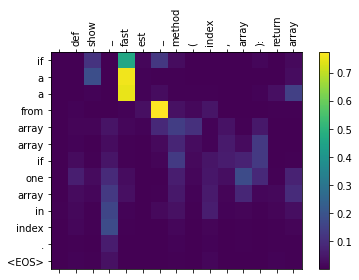

In [116]:
evaluateAndShowAttention('''def show_fastest_method(index, array):
    return array''')

In [117]:
random.choice(test_set[0])

'    def iab(self):\n        \n        if self.is_iab():\n            return IAB(self._value >> 12)\n\n'

  0%|                                                     | 0/1 [00:00<?, ?it/s]


--------------------------
def get_option(key):
    
    return _options[key]



--------------------------
Original Comment: get a global configuration option for agate . param key the name of the configuration option .
--------------------------
Generated Comment: get a global configuration key for agate . param key the name of the option .
--------------------------
Blue Score: 0.7455156903226448
--------------------------



/tmp/ipykernel_1388661/1859191800.py:161: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + tokenized_input + ['<EOS>'], rotation=90)
/tmp/ipykernel_1388661/1859191800.py:162: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_words)


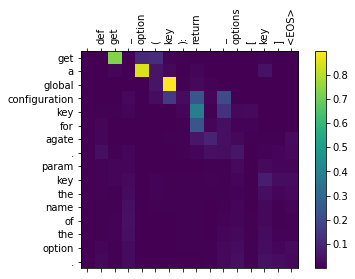

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.16it/s]


In [129]:
#evaluateRandomly(encoder1, attn_decoder1,n=1)
#evaluateAndShowMetrics(encoder1, attn_decoder1, n=10)
#evaluateAndShowMetricTable(encoder1, attn_decoder1, n=10)
#wrong_answers_only(encoder1, attn_decoder1, n=1000, plot=True, side_by_side=False)
data = best_answers_only(encoder1, attn_decoder1, n=1, plot=False, side_by_side=True, random_choice=True, show_attn=True)

#run on user entered code segment
#evaluateAndShowAttention('''def run_sorting_algorithm(algorithm, array):''')


In [79]:
data

[[0.8270194454387948,
  0.21816418380937924,
  0.5073924063435273,
  0.5664942339137129,
  0.06339436591079198,
  0.505235294090401,
  1.0,
  0.5347815767953954,
  0.4904262962069696,
  1.0,
  0.13011995735449128,
  0.7577138693378306,
  0.05764179530158987,
  0.2326762829105778,
  0.18070837905427456,
  0.3383360207054997,
  0.2899039004658233,
  0.15056669701476075,
  0.5275549332892547,
  0.23436128029906586,
  0.6224013518933145,
  1.0,
  0.150524216230665,
  0.08878743535185242,
  0.23550269637558358,
  0.8741677611478545,
  0.37150214852887053,
  0.22837269105234106,
  0.15916802013505654,
  0.07257078002384491,
  1.0,
  0.9343771613793359,
  0.8975415721423344,
  0.6759482269855531,
  0.2267893747243573,
  0.25081086861867,
  0.5936856469144757,
  0.05377825307974352,
  0.41253330499172275,
  0.7702293567417223,
  0.4889829181518734,
  0.2901660799880464,
  0.7419653160631487,
  0.289835803624655,
  0.4520808013982182,
  0.3682133462605305,
  0.8183040827806513,
  1.0,
  0.28625

In [204]:
best_answers_only(encoder1, attn_decoder1, n=1, plot=False, side_by_side=True, random=True)

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.51it/s]

>     def legacy_event_type(self):
        
        return self.name_to_event_type_map[self.name]


= return the legacy event type of the current event
< return the string name type event .
BLEU: 0.4147310221083959



In [67]:
for d in data:
    print(sum(d)/len(d))

0.48897652040391154
0.45716205074314603
0.5276080007081462
0.4452896951266251


In [81]:
plt.switch_backend('agg')

In [ ]:
#add histogram for blue score, just for kicks
#https://numpy.org/doc/stable/reference/generated/numpy.histogram.html

#TODO

In [91]:
best_answers_only(encoder1, attn_decoder1, n=100, plot=False, side_by_side=True)

  2%|▊                                          | 2/100 [00:00<00:14,  6.55it/s]

> 	def name(self):
		
		return self.__nvt_name


=  return the name of the nvt rtype str
<  return the name of the nvt rtype
BLEU: 0.8858460329277069



  5%|██▏                                        | 5/100 [00:00<00:15,  6.10it/s]

>     def fan_speed(self):
        
        return self._fan_speed


= return the fan speed of the vacuum cleaner .
< return the fan speed of the vacuum cleaner .
BLEU: 1.0

>     def tags(self):
        
        return [sent.tags for sent in self.sentences]


= return a list of tags for each sentence in this text passage .
< return a list of tags of for tags for
BLEU: 0.3802828655450092



  9%|███▊                                       | 9/100 [00:01<00:13,  6.98it/s]

> def is_abducible(observable):
    
    return issubclass(observable, _ABDUCIBLES)


= checks if an observable is abducible
< return is any
BLEU: 0.06790073189717928

>     def is_on(self) -> bool:
        
        return self._state


= return true if light is on .
< return true if device binary on .
BLEU: 0.554338922302079



 11%|████▌                                     | 11/100 [00:01<00:17,  5.10it/s]

> def active_db():
    
    dbpath = _get_project_db(get_active_project())
    return dbpath



= get the active database . returns path string file path to active project database
< return a path database the active to by db database
BLEU: 0.413976799666363



 17%|███████▏                                  | 17/100 [00:02<00:12,  6.80it/s]

> def FindByName(name):
    
    browser = Action.browser

    return browser.find_by_name(name)



= find a web element by using its name . example findbyname name 
< find a web name by name .
BLEU: 0.19503935536963202



 25%|██████████▌                               | 25/100 [00:03<00:11,  6.55it/s]

>     def get_dataset_size(self):
        
        return len(self._dataset_tagged)



= get the size of the complete available dataset . return size of the dataset .
< return the size
BLEU: 0.015011714748576597



 27%|███████████▎                              | 27/100 [00:04<00:11,  6.47it/s]

>     def is_feature(self):
        
        return self._tag == 'feature'


= check if the union tag is feature . rtype bool
< check if the union tag is soft . rtype bool
BLEU: 0.817903144224708

>     def is_owned_by(self, user):
        
        return self.owner == user


= returns true iff the passed in user is the owner of the org
< return whether is by the user .
BLEU: 0.2522457778761435



 29%|████████████▏                             | 29/100 [00:04<00:11,  6.11it/s]

> def now_reign_year():
    
    now_ = datetime.datetime.now()
    return now_.year - 2015



=  return now year reign for king .
< return the current year in date .
BLEU: 0.38570315774665637

>   def _consume_rest(line_iter):
    
    return [l for l in line_iter]


= consume and return the rest of the lines in the iterator .
< consume and the line of the .
BLEU: 0.3309868181773586



 34%|██████████████▎                           | 34/100 [00:05<00:10,  6.19it/s]

>     def bits_per_sample(self):
        

        return self.__bits_per_sample__


= returns an integer number of bits per sample this track contains .
< returns an integer number of bits per sample this track contains
BLEU: 0.9692332344763441



 35%|██████████████▋                           | 35/100 [00:05<00:12,  5.03it/s]

>     def test_get_mgr_ok_single_lfn(self):
        
        self.mtc.test_get_mgr_ok_single_lfn()


= s rse protocols get a single file from storage providing lfn success 
< xrootd rse protocols get a single file from storage providing lfn success 
BLEU: 0.9172208018899701



 37%|███████████████▌                          | 37/100 [00:05<00:10,  6.04it/s]

>     def _do_entity_name(self):
        
        return "CertificateAuthority"


= sub class hook return entity name such as for debugging .
< sub class hook return entity name such as for debugging .
BLEU: 1.0



 39%|████████████████▍                         | 39/100 [00:06<00:09,  6.53it/s]

> def is_operation(obj):
    
    return isinstance(obj, Operation)



= return if obj is a valid skein key value store operation
< return true if obj is a instance of
BLEU: 0.3464591388296516

>     def current_memory(self):
        
        return self.xml.find('currentMemory').text


= return the current memory allocated to this vm
< get the current memory of the xml
BLEU: 0.4603246088375539



 41%|█████████████████▏                        | 41/100 [00:06<00:09,  6.16it/s]

> def __split_dates_spectra(matrix):
    
    return matrix[0], matrix[1:7]



= slice the dates and spectra from the matrix and return
< return the values matrix for the . of
BLEU: 0.3504075789894677



 44%|██████████████████▍                       | 44/100 [00:06<00:08,  6.85it/s]

> def sort_by_directory(path):
    
    return 1 - path.is_directory



= returns if path is a directory otherwise for sorting 
<  the path directory the is
BLEU: 0.2451332723222368



 49%|████████████████████▌                     | 49/100 [00:07<00:07,  7.01it/s]

> def get_job_status(jobid):
    
    global r
    return r.get("%s-statcode" % jobid)


= return a job s status code
< get the job status from the job
BLEU: 0.39422708980027554



 51%|█████████████████████▍                    | 51/100 [00:07<00:06,  7.21it/s]

>     def wait_completion(self):
        
        self.tasks.join()


= wait for completion of all the tasks in the queue
< wait for completion of all the tasks in the queue
BLEU: 1.0



 53%|██████████████████████▎                   | 53/100 [00:08<00:07,  6.30it/s]

>     def get_used_size_from_instance(self, instance):
        
        raise NotImplementedError()


= method used in update infra instances sizes . return used size in bytes from instance .
< get a size of the instance .
BLEU: 0.07868235647726078



 56%|███████████████████████▌                  | 56/100 [00:08<00:06,  6.34it/s]

>     def is_ready(self, task_id):
        
        return True


= return whether task with identifier task id is ready . parameters task id int
< return whether is the id
BLEU: 0.08932920282197845



 64%|██████████████████████████▉               | 64/100 [00:09<00:05,  6.45it/s]

> def boundary(value, minvalue, maxvalue):
    
    return min(max(value, minvalue), maxvalue)


= limit a value between a minvalue and maxvalue
< limit a value minvalue and maxvalue
BLEU: 0.7337830761222462

>     def _common_da_resource_commands(self):
        
        return [
        ]


= return a list of the common resource commands for da return list of da commands
< return the first common specific
BLEU: 0.13397724626337879



 66%|███████████████████████████▋              | 66/100 [00:10<00:05,  6.00it/s]

>     def device_state_attributes(self):
        
        return {CONF_DEVICE: self._device}


= return the state attributes of the device .
< return the state attributes of the device .
BLEU: 1.0

> def config_get_float(section, option):
    
    return __CONFIG.getfloat(section, option)



= return the floating point value for a given option in a section
< return the in a given option in option .
BLEU: 0.4597241092522835



 69%|████████████████████████████▉             | 69/100 [00:10<00:05,  5.79it/s]

>     def get_movie(self, _id):
        
        raise NotImplementedError()


= get a movie object from an id . param id id of movie type id str rtype class movie 
< get a weather . a id of
BLEU: 0.03849401347866918



 75%|███████████████████████████████▌          | 75/100 [00:11<00:03,  6.77it/s]

> def type_or_none(typerefs, value):
    
    return isinstance(value, typerefs) or value is None


= provides a helper function to check that a value is of the types passed or none .
< given the value or the type
BLEU: 0.09462722835211533

> def transpose(list_of_lists):
    
    # Your code goes here
    pass


= transpose a list of lists .
< move the list of lists to
BLEU: 0.5710489853816264



 76%|███████████████████████████████▉          | 76/100 [00:11<00:03,  6.69it/s]

> def get_job_status(jobid):
    
    global r
    return r.get("%s-statcode" % jobid)


= return a job s status code
< get the job status from the job
BLEU: 0.39422708980027554

> def list_registry_opts():
    
    return [(g, copy.deepcopy(o)) for g, o in _registry_opts]



= return a list of oslo config options available in glance registry service .
< return a list of oslo config
BLEU: 0.18664041484472882



 79%|█████████████████████████████████▏        | 79/100 [00:12<00:03,  6.43it/s]

>     def _is_standalone(self, spoke):
        
        return isinstance(spoke, StandaloneSpoke)


= checks if the passed spoke is standalone .
< checks if spoke is standalone
BLEU: 0.6201948221781713



 80%|█████████████████████████████████▌        | 80/100 [00:12<00:03,  6.11it/s]

> def __virtual__():
    
    return 'layman' if 'layman.add' in __salt__ else False



= only load if the layman module is available in salt 
< only load if the smtp module is available in salt 
BLEU: 0.8554938264067169



 85%|███████████████████████████████████▋      | 85/100 [00:13<00:02,  5.94it/s]

> def verify_any(func, *args, **kwargs):
    
    return _verify(func, 'any', *args, **kwargs)


= assert that any of func args kwargs are true .
< assert func kwargs func kwargs main
BLEU: 0.43677727405618577



 90%|█████████████████████████████████████▊    | 90/100 [00:14<00:01,  6.22it/s]

>     def long_name_type():
        

        return "Serial"


= returns the long name type for this port . returns string
< returns the long name type for this port . returns
BLEU: 0.8693582353988059

>     def data_name(self):
        
        return self._decoder.data_tensor_name


= the name of the data tensor .
< the name of tensor data the
BLEU: 0.8782184063444409



 93%|███████████████████████████████████████   | 93/100 [00:14<00:01,  6.19it/s]

>     def close_all(self):
        
        for f in self._all_figures:
            plt.close(f)


= close all figures spawned by this class .
< close in .
BLEU: 0.02769571593146309



 96%|████████████████████████████████████████▎ | 96/100 [00:15<00:00,  6.19it/s]

>     def get_number_of_notes(self):
        
        return self._get_number_of(NOTE_KEY)


= return the number of notes currently in the database .
< return the number of sources currently in the database .
BLEU: 0.8842444901834833

>     def get_board_name(self):
        
        return "Virtual"


= return the name of the board of this driver .
< return the name of the board of this switch .
BLEU: 0.8377345655738011



100%|█████████████████████████████████████████| 100/100 [00:15<00:00,  6.27it/s]

> def device_is_dm_mpath(info):
    
    return device_dm_subsystem_match(info, "mpath")



= return true if the device is a multipath device .
< return true if the device is a cciss .
BLEU: 0.6286959341081599



input = def run_sorting_algorithm(algorithm, array):
output = update the python binary on parameters . <EOS>


/tmp/ipykernel_2542220/1353268929.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + input_sentence.split(' ') +
/tmp/ipykernel_2542220/1353268929.py:57: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_words)


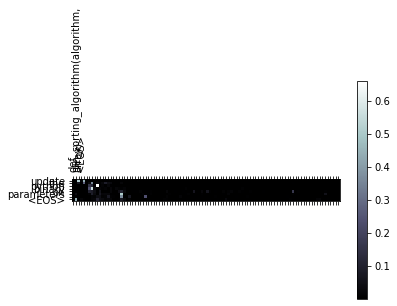

In [29]:
evaluateAndShowAttention('''def run_sorting_algorithm(algorithm, array):''')

input =     n = len(array)
    for i in range(n):
        already_sorted = True
        for j in range(n - i - 1):
            if array[j] > array[j + 1]:
                array[j], array[j + 1] = array[j + 1], array[j]
                already_sorted = False
        if already_sorted:
            break
    return array
output = return the in bit bit with t in form and and and and and n in bits and x . <EOS>


/tmp/ipykernel_2542220/1353268929.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + input_sentence.split(' ') +
/tmp/ipykernel_2542220/1353268929.py:57: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_words)


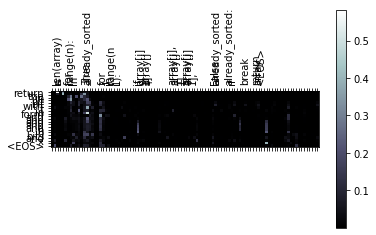

In [30]:
evaluateAndShowAttention('''    n = len(array)
    for i in range(n):
        already_sorted = True
        for j in range(n - i - 1):
            if array[j] > array[j + 1]:
                array[j], array[j + 1] = array[j + 1], array[j]
                already_sorted = False
        if already_sorted:
            break
    return array''')